## Importing Libraries and Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import time
from time import time

In [2]:
tweets = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
print("Train shape: ", tweets.shape)
print("Test shape ", test_data.shape)

Train shape:  (7613, 5)
Test shape  (3263, 4)


In [4]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


`keyword` and `location` coulumns have a lot of missing values. But the `text` and `target` columns both have 7613 entries. Those are the columns we are concerned with. Just to confirm, we will check the `text` and `target` columns for NULL values.

In [6]:
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# Creating a table to track results
results = pd.DataFrame(columns=[
                    "Experiment Name", 
                    "Cross fold train F1", 
                    "Val F1", 
                    "Val Acc",
                    "Train Taken (s)", 
                    "Test Time (s)"
            ])

## Baseline Logistic Regression

In [8]:
tfidf = TfidfVectorizer()

In [9]:
X_train = tfidf.fit_transform(tweets["text"])
y_train = tweets["target"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [10]:
lr = LogisticRegression()

start = time()
lr.fit(X_train, y_train)
train_time = round(time() - start, 3)

In [11]:
start = time()
y_pred = lr.predict(X_test)
test_time = round(time() - start, 3)

In [12]:
pred_prob = lr.predict_proba(X_test)
accuracy = lr.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)

print('Accuracy of Logistic Regression on test set: {:.2f}'.format(accuracy))
print('F1 score of Logisitic Regression on test set: {:.3f}'.format(f1))

Accuracy of Logistic Regression on test set: 0.81
F1 score of Logisitic Regression on test set: 0.746


In [13]:
results.loc[0] = ["Baseline LR", 
                  "-", 
                  round(f1, 3), 
                  round(lr.score(X_test, y_test), 3), 
                  train_time, 
                  test_time
                 ]

In [14]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.513,0.001


In [15]:
# Preparing data for grid search
X_train = tweets['text']
y_train = tweets['target']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

## Logisitic Regression

In [17]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__penalty': ('l1', 'l2'),
    # 'clf__tol': (0.0001, 0.00001, 0.0000001),
    'clf__C': (10, 1, 0.1, 0.01),
    'clf__max_iter': (50, 80, 200),
}
    
# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

lr_gs = GridSearchCV(lr_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.9s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.9s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   2.6s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   2.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   2.6s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tf

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.6s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   8.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, cl

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=  10.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   1.9s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   4.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   4.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l2, clf__solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.9s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   1.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   2.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solve

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__C=1, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=1, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': (10, 1, 0.1, 0.01),
                         'clf__max_iter': (50, 80, 200),
                         'clf__penalty': ('l1', 'l2'),
                         'clf__solver': ['liblinear', 'saga'],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [18]:
print("F1 score for the model with best parameters:", round(lr_gs.best_score_, 3))
print("Best parameters: ", lr_gs.best_params_)

F1 score for the model with best parameters: 0.747
Best parameters:  {'clf__C': 10, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__norm': 'l2', 'tfidf__use_idf': False}


In [19]:
# Best estimator fitting time
start = time()
lr_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [20]:
start = time()
y_pred = lr_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.813
F1 Score on the test set:  0.777


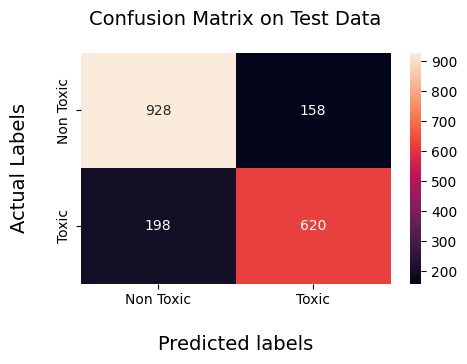

In [21]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1086
           1       0.80      0.76      0.78       818

    accuracy                           0.81      1904
   macro avg       0.81      0.81      0.81      1904
weighted avg       0.81      0.81      0.81      1904



In [23]:
results.loc[len(results)] = [
        "Logistic Regression", 
        round(lr_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [24]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.513,0.001
1,Logistic Regression,0.747,0.777,0.813,0.387,0.053


## SGD Classifier

In [25]:
sgd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__loss': ('hinge', 'perceptron', 'log_loss'),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__tol': (0.0001, 0.00001, 0.0000001), 
    'clf__alpha': (0.1, 0.01, 0.001, 0.0001), 
}

    
# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
sgd_gs = GridSearchCV(sgd_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
sgd_gs.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, cl

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.000

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptr

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=per

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.6s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   1.5s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   1.5s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=p

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.6s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.8s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.8s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.8s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__p

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001,

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=Tr

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alph

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   2.2s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   1.9s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.001, clf__loss=lo

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__alpha=0.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.1, 0.01, 0.001, 0.0001),
                         'clf__loss': ('hinge', 'perceptron', 'log_loss'),
                         'clf__penalty': ('l1', 'l2', 'elasticnet'),
                         'clf__tol': (0.0001, 1e-05, 1e-07),
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [26]:
print("F1 score for the model with best parameters:", round(sgd_gs.best_score_, 3))
print("Best parameters: ", sgd_gs.best_params_)

F1 score for the model with best parameters: 0.752
Best parameters:  {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'elasticnet', 'clf__tol': 1e-07, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}


In [27]:
# Best estimator fitting time
start = time()
sgd_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [28]:
start = time()
y_pred = sgd_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.817
F1 Score on the test set:  0.775


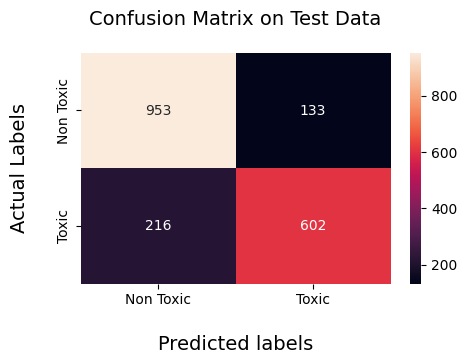

In [29]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1086
           1       0.82      0.74      0.78       818

    accuracy                           0.82      1904
   macro avg       0.82      0.81      0.81      1904
weighted avg       0.82      0.82      0.82      1904



In [31]:
results.loc[len(results)] = [
        "Stochastic GD Classifier", 
        round(sgd_gs.best_score_, 3),  
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [32]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.5130,0.001
1,Logistic Regression,0.747,0.777,0.813,0.3870,0.053
2,Stochastic GD Classifier,0.752,0.775,0.817,0.7934,0.051


## Random Forest Classifier

In [33]:
rfc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__max_depth': [None, 9, 15, 22],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [2, 5, 10],
    'clf__n_estimators':[80, 150, 200],
    'clf__criterion':['gini','entropy']
}

# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
rfc_gs = GridSearchCV(rfc_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__alpha=0.0001, clf__loss=log_loss, clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 9, 15, 22],
                         'clf__min_samples_leaf': [2, 5, 10],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [80, 150, 200],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [34]:
print("Score for the model with best parameters:", round(rfc_gs.best_score_, 3))
print("Best parameters: ", rfc_gs.best_params_)

Score for the model with best parameters: 0.718
Best parameters:  {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 150, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}


In [35]:
# Best estimator fitting time
start = time()
rfc_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [36]:
start = time()
y_pred = rfc_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.8
F1 Score on the test set:  0.738


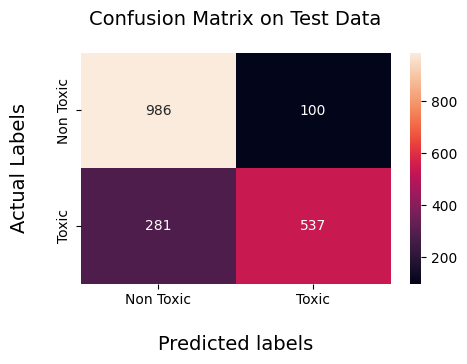

In [37]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1086
           1       0.84      0.66      0.74       818

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [39]:
results.loc[len(results)] = [
        "Random Forest Classifier", 
        round(rfc_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [40]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.5130,0.001
1,Logistic Regression,0.747,0.777,0.813,0.3870,0.053
2,Stochastic GD Classifier,0.752,0.775,0.817,0.7934,0.051
3,Random Forest Classifier,0.718,0.738,0.800,3.4869,0.194


## Support Vector Classifier

In [41]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__kernel': ('rbf', 'poly'),     
    'clf__degree': (1, 2, 3, 4, 5),
    'clf__C': (10, 1, 0.1, 0.01),
}


# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
svc_gs = GridSearchCV(svc_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=200, tfidf__norm=l2, tfidf__use_idf=True; total time=   1.7s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=200, tfidf__norm=l2, tfidf__use_idf=False; total time=   1.7s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.8s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.8s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.8s
[CV] END clf__criterion

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': (10, 1, 0.1, 0.01),
                         'clf__degree': (1, 2, 3, 4, 5),
                         'clf__kernel': ('rbf', 'poly'),
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [42]:
print("Score for the model with best parameters:", round(svc_gs.best_score_, 3))
print("Best parameters: ", svc_gs.best_params_)

Score for the model with best parameters: 0.752
Best parameters:  {'clf__C': 1, 'clf__degree': 1, 'clf__kernel': 'poly', 'tfidf__norm': 'l2', 'tfidf__use_idf': True}


In [43]:
# Best estimator fitting time
start = time()
svc_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [44]:
start = time()
y_pred = svc_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.819
F1 Score on the test set:  0.778


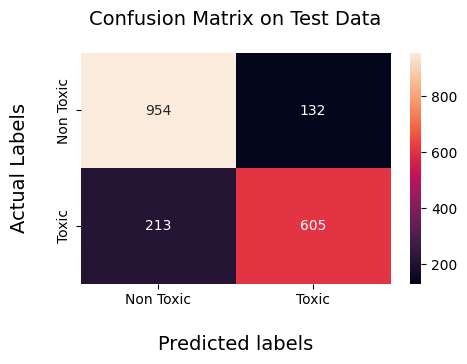

In [45]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1086
           1       0.82      0.74      0.78       818

    accuracy                           0.82      1904
   macro avg       0.82      0.81      0.81      1904
weighted avg       0.82      0.82      0.82      1904



In [47]:
results.loc[len(results)] = [
        "Support Vector Classifier", 
        round(svc_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [48]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.5130,0.001
1,Logistic Regression,0.747,0.777,0.813,0.3870,0.053
2,Stochastic GD Classifier,0.752,0.775,0.817,0.7934,0.051
3,Random Forest Classifier,0.718,0.738,0.800,3.4869,0.194
4,Support Vector Classifier,0.752,0.778,0.819,4.8470,1.173


## Voting Classifier
Here I will take the 4 models and run them through a voting classifier

In [49]:
lr_vc = lr_gs.best_estimator_
sgd_vc = sgd_gs.best_estimator_
rfc_vc = rfc_gs.best_estimator_
svc_vc = svc_gs.best_estimator_

estimators = [
    ('lr', lr_vc), 
    ('sgd', sgd_vc), 
    ('rfc', rfc_vc),
    ('svc', sgd_vc)
]

In [50]:
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

vc_clf = VotingClassifier(estimators=estimators, voting='hard')
scores = cross_val_score(vc_clf, X_train, y_train, scoring='f1', cv=strat_kf)

start = time()
print('F1 Score on training set: ', round(scores.mean(), 3))
ensemble_model = vc_clf.fit(X_train, y_train)
train_time = round(time() - start, 3)

start = time()
y_pred = ensemble_model.predict(X_test)
test_time = round(time() - start, 3)

F1 Score on training set:  0.75


In [51]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.82
F1 Score on the test set:  0.777


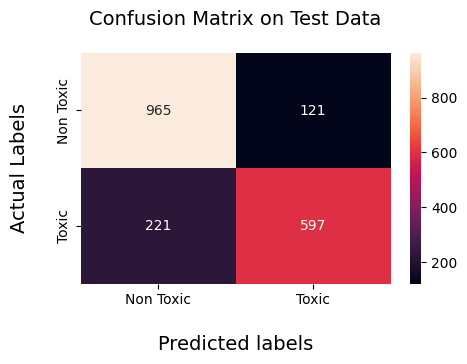

In [52]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1086
           1       0.83      0.73      0.78       818

    accuracy                           0.82      1904
   macro avg       0.82      0.81      0.81      1904
weighted avg       0.82      0.82      0.82      1904



In [54]:
results.loc[len(results)] = [
        "Voting Classifier", 
        round(scores.mean(), 3),
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [55]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.746,0.807,0.5130,0.001
1,Logistic Regression,0.747,0.777,0.813,0.3870,0.053
2,Stochastic GD Classifier,0.752,0.775,0.817,0.7934,0.051
3,Random Forest Classifier,0.718,0.738,0.800,3.4869,0.194
4,Support Vector Classifier,0.752,0.778,0.819,4.8470,1.173
5,Voting Classifier,0.75,0.777,0.820,5.2730,0.359


## Generating Test Predictions

In [56]:
# Retraining with full dataset
tweets = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [57]:
X_train, y_train = tweets['text'], tweets['target']
X_test = test_data['text']

In [58]:
svc_gs.best_estimator_.fit(X_train, y_train)
y_pred = svc_gs.best_estimator_.predict(X_test)
test_data['target'] = y_pred
test_data.drop(['text','keyword','location'], axis=1, inplace=True)

In [59]:
test_data.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [60]:
test_data.to_csv('submission.csv', index=False)